In [1]:
# User-definable parameters
parameters = {
    "fasta_file_name": "data/190912_BovineHistone_cRAP_MPDS_01.fasta",
    "max_pep_len": 20,
    "charges": [2, 3],
    "ppm": 10,
    "isotopes": [0, 1],
    "explicit_isoform_format": "prop-{}-OH",
    "variable_mods": {
        'me': ['K', "R"],
        'me2': ['K'],
        'me3': ['K'],
        'ac': ['K'],
        'fo': ['K'],
    },
    "MGF_file_names": {
        "light_c13": "data/mgf/LightC_KSAPAT.mgf",
        "light_deuterium": "data/mgf/LightD_KSAPAT.mgf",
        "c13": "data/mgf/HeavyC_KSAPAT.mgf",
        "deuterium": "data/mgf/HeavyD_KSAPAT.mgf",   
    }
}

In [2]:
import pyteomics
import pyteomics.fasta
import pyteomics.parser
import pyteomics.electrochem
import pyteomics.mass
import pyteomics.mgf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def setAAComp(fixed_ptm_type):
    aa_comp = {
        key: pyteomics.mass.Composition(value) for key, value in pyteomics.mass.std_aa_comp.items()
    }
    if fixed_ptm_type == "light":
        fixed_ptm = pyteomics.mass.Composition('C3H4O1')
    elif fixed_ptm_type == "c13":
        fixed_ptm = pyteomics.mass.Composition('C[13]3H4O1')
    elif fixed_ptm_type == "deuterium":
        fixed_ptm = pyteomics.mass.Composition('C3H[2]5H-1O1')
    elif fixed_ptm_type == "none":
        fixed_ptm = pyteomics.mass.Composition('')
#     elif fixed_ptm_type == "heavy_acetyl":
#         fixed_ptm = mass.Composition('C2H[2]3O1H-1')
    else:
        raise Exception("Undefined fixed_ptm_type")
    aa_comp['K'] += fixed_ptm
    aa_comp['prop-'] = fixed_ptm + pyteomics.mass.Composition("H1")
    aa_comp.update(
        {
            'me': pyteomics.mass.Composition('C1H2'),
            'me2': pyteomics.mass.Composition('C2H4') - fixed_ptm,
            'me3': pyteomics.mass.Composition('C3H6') - fixed_ptm,
            'fo': pyteomics.mass.Composition('C1O1') - fixed_ptm,
            'ac': pyteomics.mass.Composition('C2H2O1') - fixed_ptm,
        }
    )
    return aa_comp

def getIsoforms(parameters, description_must_contain="istone", protease="arg-c"):
    fasta_file = pyteomics.fasta.FASTA(parameters["fasta_file_name"])
    peptides = set()
    isoforms = set()
    for description, sequence in fasta_file:
        if description_must_contain not in description:
            continue
        new_peptides = pyteomics.parser.cleave(
            sequence,
            pyteomics.parser.expasy_rules[protease]
        )
        peptides.update(
            {
                pep for pep in new_peptides if len(pep) < parameters["max_pep_len"]
            }
        )
    isoforms = {
        parameters["explicit_isoform_format"].format(
            isoform
        ) for peptide in peptides for isoform in pyteomics.parser.isoforms(
            peptide,
            variable_mods=parameters["variable_mods"]
        )
    }
    return isoforms


def getIsoformMasses(parameters, isoforms, fixed_ptm_type, isotope_mass=1.0028):
    masses = np.sort(
        [
            pyteomics.mass.calculate_mass(
                sequence=isoform,
                charge=charge,
                aa_comp=setAAComp(fixed_ptm_type)
            ) + isotope_mass * isotope / charge for isoform in isoforms for charge in parameters['charges'] for isotope in parameters['isotopes']
        ]
    )
    return masses

def getMZRanges(parameters, masses):
    lower_masses = masses / (1 + parameters["ppm"] / 10**6)
    upper_masses = masses * (1 + parameters["ppm"] / 10**6)
    all_masses = np.concatenate([lower_masses, upper_masses])
    frequencies = np.ones(len(all_masses), dtype=np.int)
    frequencies[len(frequencies) // 2:] = -1
    order = np.argsort(all_masses)
    all_masses = all_masses[order]
    frequencies = np.cumsum(frequencies[order])
    mz_range = np.diff(all_masses)
    selection = mz_range > 0
    select_masses = all_masses[:-1][selection]
    select_mz_range = mz_range[selection]
    select_frequencies = frequencies[:-1][selection]
    selection = select_frequencies > 0
    mz_ranges = np.stack(
        [
            select_masses,
            select_mz_range,
            select_frequencies,
        ]
    ).T[selection]
    return mz_ranges

def plotMzRanges(mz_ranges, mirrored=False):
    left_masses = mz_ranges[:, 0]
    right_masses = mz_ranges[:, 0] + mz_ranges[:, 1]
    right_masses = right_masses[~np.isin(right_masses, left_masses)]
    masses = np.concatenate([left_masses, right_masses])
    frequencies = np.zeros(len(masses), dtype=int)
    frequencies[:mz_ranges.shape[0]] = mz_ranges[:, 2]
    order = np.argsort(masses)
    masses = masses[order]
    frequencies = frequencies[order]
    if mirrored:
        frequencies *= -1
    plt.step(masses, frequencies, where="post")
#     plt.bar(
#         x=mz_ranges[:,0],
#         width=mz_ranges[:,1],
#         height=mz_ranges[:,2],
#         align="edge",
#         linewidth=0
#     )

def getAmbiguityIndex(mz_ranges):
    ranges = mz_ranges[:, 1]
    frequencies = mz_ranges[:, 2]
#     ambiguity_index = np.sum(frequencies**2 * ranges / np.sum(ranges * frequencies))
    ambiguity_index = np.sum(frequencies * ranges / np.sum(ranges))
    return ambiguity_index

In [3]:
isoforms = getIsoforms(parameters)

In [4]:
light_masses = getIsoformMasses(parameters, isoforms, "light")
light_mz_ranges = getMZRanges(parameters, light_masses)

c13_masses = getIsoformMasses(parameters, isoforms, "c13")
c13_mz_ranges = getMZRanges(parameters, c13_masses)

deuterium_masses = getIsoformMasses(parameters, isoforms, "deuterium")
deuterium_mz_ranges = getMZRanges(parameters, deuterium_masses)

<IPython.core.display.Javascript object>


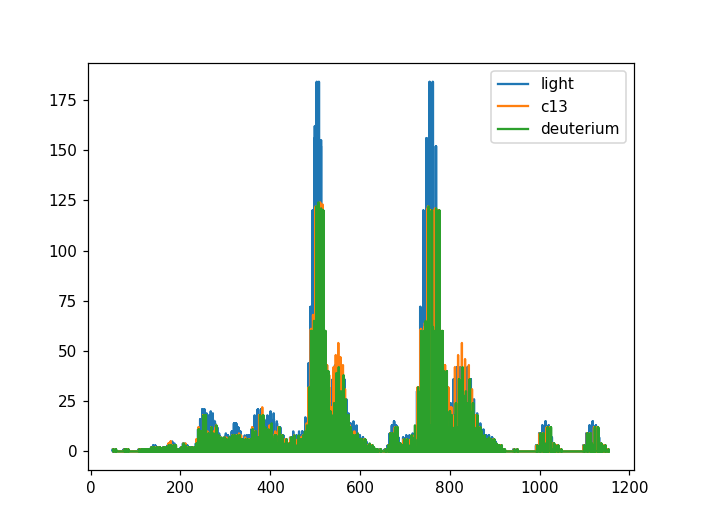

In [5]:
%matplotlib notebook
plotMzRanges(light_mz_ranges)
plotMzRanges(c13_mz_ranges)
plotMzRanges(deuterium_mz_ranges)
plt.legend(["light", "c13", "deuterium"])

In [6]:
print("Isoforms: {}\n".format(len(isoforms)))
print("-" * 50)
print("PTM\t\tMZ range\tAmbiguity index")
print("-" * 50)
for fixed_ptm, mz_ranges in [
    ("light\t", light_mz_ranges),
    ("c13\t", c13_mz_ranges),
    ("deuterium", deuterium_mz_ranges),
]:
    print(
        "{}\t{:.3f}\t\t{:.3f}".format(
            fixed_ptm,
            np.sum(mz_ranges[:, 1]),
            getAmbiguityIndex(mz_ranges),
        )
    )
print("-" * 50)

Isoforms: 5739

--------------------------------------------------
PTM		MZ range	Ambiguity index
--------------------------------------------------
light		28.547		9.572
c13		36.593		7.499
deuterium	37.483		7.342
--------------------------------------------------


In [7]:
def getMZsFromMGF(mgf_file_name):
    precursor_masses = np.array(
        [
            spectrum['params']['pepmass'][0] for spectrum in pyteomics.mgf.MGF(mgf_file_name)
        ]
    )
    masses = np.stack(
        [
            *np.unique(precursor_masses, return_counts=True)
        ]
    ).T
    return masses

def getHitCounts(masses, mz_ranges):
    mgf_masses = masses[:, 0]
    mgf_frequencies = masses[:, 1]
    indices = np.searchsorted(
        mz_ranges[:, 0],
        mgf_masses,
    ) - 1
    hits = mgf_masses < (
        mz_ranges[indices, 0] + mz_ranges[indices, 1]
    )
    hit_counts = np.zeros(len(mgf_masses), dtype=int)
    hit_counts[hits] = mz_ranges[indices[hits], 2]
    return hit_counts

def getAmbiguity(hit_counts, frequencies):
    ambiguity = np.sum(hit_counts * frequencies) / np.sum((hit_counts > 0) * frequencies)
    return ambiguity

In [8]:
light_c13_mgf_masses = getMZsFromMGF(parameters["MGF_file_names"]["light_c13"])
light_deuterium_mgf_masses = getMZsFromMGF(parameters["MGF_file_names"]["light_deuterium"])
c13_mgf_masses = getMZsFromMGF(parameters["MGF_file_names"]["c13"])
deuterium_mgf_masses = getMZsFromMGF(parameters["MGF_file_names"]["deuterium"])

In [9]:
light_c13_hit_counts = getHitCounts(light_c13_mgf_masses, light_mz_ranges)
light_deuterium_hit_counts = getHitCounts(light_deuterium_mgf_masses, light_mz_ranges)
c13_hit_counts = getHitCounts(c13_mgf_masses, c13_mz_ranges)
deuterium_hit_counts = getHitCounts(deuterium_mgf_masses, deuterium_mz_ranges)

In [10]:
print("-" * 65)
print("{:<20} {:<15} {:<15} {}".format("PTM", "Precursors", "Annotatable" ,"Ambiguity"))
print("-" * 65)
for fixed_ptm, hit_counts, frequencies in [
    ("light_c13", light_c13_hit_counts, light_c13_mgf_masses[:, 1]),
    ("light_deuterium", light_deuterium_hit_counts, light_deuterium_mgf_masses[:, 1]),
    ("c13", c13_hit_counts, c13_mgf_masses[:, 1]),
    ("deuterium", deuterium_hit_counts, deuterium_mgf_masses[:, 1]),
]:
    print(
        "{:<20} {:<15} {:<15} {:.3f}".format(
            fixed_ptm,
            np.sum(frequencies.astype(np.int)),
            np.sum((frequencies * (hit_counts > 0)).astype(np.int)),
            getAmbiguity(hit_counts, frequencies)
        )
    )
print("-" * 65)

-----------------------------------------------------------------
PTM                  Precursors      Annotatable     Ambiguity
-----------------------------------------------------------------
light_c13            40430           4838            13.727
light_deuterium      26157           3811            13.090
c13                  37719           4594            7.589
deuterium            25523           3787            7.652
-----------------------------------------------------------------


In [11]:
# %matplotlib notebook
# # sns.jointplot(light_mgf_frequencies[hit_counts > 0], hit_counts[hit_counts > 0])
# # data = np.zeros((np.max(hit_counts) + 1, np.max(light_mgf_frequencies.astype(int) + 1)))
# # for x, y in zip(hit_counts, light_mgf_frequencies.astype(int)):
# #     if x != 0:
# #         data[x, y] += 1
# # sns.heatmap(np.log(data + 1))
# # sns.jointplot(mgf_masses[:,0], mgf_masses[:,1])

# mz_dist = 0.7
# lower_masses = mgf_masses[:,0] - mz_dist
# upper_masses = mgf_masses[:,0] + mz_dist
# # ppm = 10
# # lower_masses = mgf_masses[:,0] / (1 + ppm / 10**6)
# # upper_masses = mgf_masses[:,0] * (1 + ppm / 10**6)
# all_masses = np.concatenate([lower_masses, upper_masses])
# frequencies = np.zeros(len(all_masses), dtype=np.int)
# frequencies[:len(frequencies) // 2] = mgf_masses[:,1]
# frequencies[len(frequencies) // 2:] = - mgf_masses[:,1]
# order = np.argsort(all_masses)
# all_masses = all_masses[order]
# frequencies = np.cumsum(frequencies[order])
# mz_range = np.diff(all_masses)
# selection = mz_range > 0
# select_masses = all_masses[:-1][selection]
# select_mz_range = mz_range[selection]
# select_frequencies = frequencies[:-1][selection]
# selection = select_frequencies > 0
# mz_ranges = np.stack(
#     [
#         select_masses,
#         select_mz_range,
#         select_frequencies,
#     ]
# ).T[selection]
# plotMzRanges(light_mz_ranges)
# plotMzRanges(mz_ranges, mirrored=True)